# Modelo de IA

## Instalacion de librerias, dependencias, e importacion de la data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import re
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import gensim
import os
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from transformers import pipeline
from collections import Counter
from wordcloud import WordCloud
from gensim import corpora
from huggingface_hub import login
import torch

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##Verificar si se está utilizando GPU

In [ ]:
device = 0 if torch.cuda.is_available() else -1

In [ ]:
comments_file_path = ('RUTA')
comments_df = pd.read_parquet(comments_file_path)
comments_df.head()

,store,assigned_at,answer
0,FN60,2023-02-20 12:25:30.652022,"Todo lo hacen perfecto,, gracias por su atención"
1,FN54,2023-02-20 17:10:31.230531,Ya no ay probadores
2,T060,2023-02-21 18:55:32.949118,Excelente servicio
3,FN88,2023-02-24 16:25:54.015137,Buen servicio
4,T036,2023-02-21 19:25:33.154527,EL personal disperso y eso que estaba solo el ...


##Función de preprocesamiento, tokenizar y lematizar

In [ ]:
def prepro_text(text):
    """
    Preprocesa el texto: lo convierte a minúsculas, elimina caracteres especiales y espacios adicionales, tokeniza y lematiza.

    Args:
        text (str): El texto a preprocesar.

    Returns:
        str: El texto preprocesado.
    """
    if isinstance(text, float):
        return ""

    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)

    tokens = word_tokenize(text)

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

comments_df['processed_answer'] = comments_df['answer'].astype(str).apply(prepro_text)

comments_df[['answer', 'processed_answer']].head()


,answer,processed_answer
0,"Todo lo hacen perfecto,, gracias por su atención",todo lo hacen perfecto gracias por su atención
1,Ya no ay probadores,ya no ay probadores
2,Excelente servicio,excelente servicio
3,Buen servicio,buen servicio
4,EL personal disperso y eso que estaba solo el ...,el personal disperso y eso que estaba solo el ...


##Análisis de frecuencia eliminando ruido manualmente, para llevar el procesamiento lo mas transparente posible!

In [ ]:
stop_words = {'la', 'de', 'y', "muy", "me", "que", "en", "no", "los",
              'el', 'por', 'e', 'a', 'con', 'mi','mas','una','un', 'se', 'lo', 'al','none',
              'son', 'mas','su', 'del','sus', 'le', 'más', 'para','tienda', 'hay', 'bien',
              "ropa", 'ropa', 'prendas', 'buen', 'pero', "niños", 'q', 'exelente', "todo"}

all_words = ' '.join(comments_df['processed_answer']).split()

filtered_words = [word for word in all_words if word.lower() not in stop_words]

word_freq = Counter(filtered_words)

word_freq.most_common(10)

[('excelente', 2054),
 ('atención', 1691),
 ('calidad', 1227),
 ('buena', 1176),
 ('gracias', 1004),
 ('servicio', 840),
 ('marca', 652),
 ('productos', 630),
 ('encanta', 556),
 ('siempre', 352)]

La percepción general de los clientes hacia la marca y sus productos es altamente positiva, como se refleja en las palabras más utilizadas en los comentarios. Esto sugiere que la empresa ha logrado establecer una reputación sólida basada en la calidad de sus productos, la atención al cliente y la satisfacción general de los clientes. Este nivel de satisfacción puede resultar en clientes recurrentes y recomendaciones positivas, lo que contribuye al crecimiento y éxito continuo del negocio.

## Nube de palabras "Gratificacion a colaboradores"

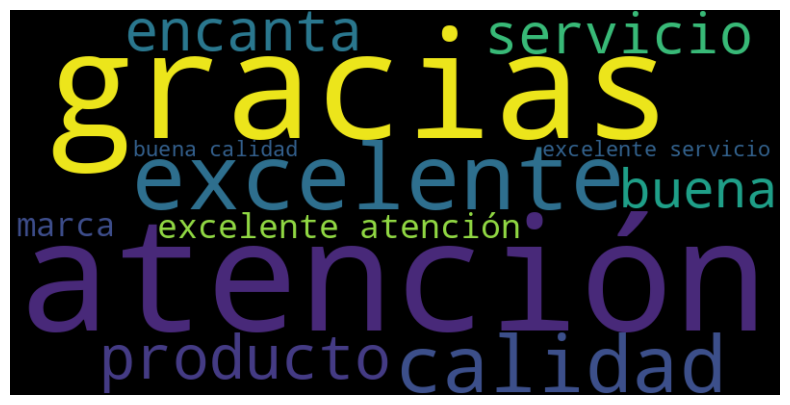

In [ ]:
excluded_words = ['la', 'de', 'y', "muy", "me", "que", "en", "no", "los",
                  'el', 'por', 'e', 'a', 'con', 'mi','mas','una','un', 'se', 'lo', 'al','none',
                  'son', 'mas','su', 'del','sus', 'le', 'más', 'para','tienda', 'hay', 'bien',
                  "ropa", 'ropa', 'prendas', 'buen', 'pero', "niños", 'q', 'exelente', "todo", "gracia",
                  "talla", "descuento"]

wordcloud = WordCloud(width=800, height=400, stopwords=excluded_words).generate(' '.join(all_words))

word_frequencies = wordcloud.words_

top_words = dict(sorted(word_frequencies.items(), key=lambda item: item[1], reverse=True)[:12])

wordcloud_top15 = WordCloud(width=800, height=400).generate_from_frequencies(top_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_top15, interpolation='bilinear')
plt.axis('off')
plt.show()

## Análisis de Sentimiento


Este código integra el modelo de análisis de sentimientos nlptown/bert-base-multilingual-uncased-sentiment de Hugging Face

In [ ]:
def get_sentiment_batch(texts, sentiment_pipeline):
    """
    Analiza el sentimiento de una lista de textos usando el pipeline de Hugging Face en modo batch.

    Args:
        texts (list): Lista de textos a analizar.
        sentiment_pipeline (transformers.pipelines.Pipeline): Pipeline de análisis de sentimiento.

    Returns:
        list: Lista de diccionarios con las puntuaciones de sentimiento para cada texto.
    """
    results = sentiment_pipeline(texts)
    sentiment_scores = []
    for result in results:
        scores = {
            'neg': 1 - result['score'] if result['label'] == '1 star' else 0,
            'neu': result['score'] if result['label'] == '3 stars' else 0,
            'pos': result['score'] if result['label'] in ['4 stars', '5 stars'] else 0,
            'compound': result['score'] if result['label'] in ['4 stars', '5 stars'] else -result['score']
        }
        sentiment_scores.append(scores)
    return sentiment_scores

sentiment_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment", device=device)
batch_size = 32


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

,processed_answer,sentiment
0,todo lo hacen perfecto gracias por su atención,"{'neg': 0, 'neu': 0, 'pos': 0.753455400466919,..."
1,ya no ay probadores,"{'neg': 0.5940508544445038, 'neu': 0, 'pos': 0..."
2,excelente servicio,"{'neg': 0, 'neu': 0, 'pos': 0.6990302801132202..."
3,buen servicio,"{'neg': 0, 'neu': 0, 'pos': 0.4445280134677887..."
4,el personal disperso y eso que estaba solo el ...,"{'neg': 0.34849053621292114, 'neu': 0, 'pos': ..."
5,muy buenas ofertas,"{'neg': 0, 'neu': 0, 'pos': 0.6776486039161682..."
6,excelente presentación todo muy bien organizad...,"{'neg': 0, 'neu': 0, 'pos': 0.7006896734237671..."
7,nada,"{'neg': 0.3993200659751892, 'neu': 0, 'pos': 0..."
8,los felicito,"{'neg': 0, 'neu': 0, 'pos': 0.629511833190918,..."
9,excelente,"{'neg': 0, 'neu': 0, 'pos': 0.785732090473175,..."


##Procesamiento en lotes

In [ ]:

sentiment_results = []
for i in range(0, len(comments_df), batch_size):
    batch_texts = comments_df['processed_answer'][i:i + batch_size].tolist()
    batch_sentiments = get_sentiment_batch(batch_texts, sentiment_pipeline)
    sentiment_results.extend(batch_sentiments)

comments_df['sentiment'] = sentiment_results

comments_df[['processed_answer', 'sentiment']].head(50)

## Grafica de sentimiento

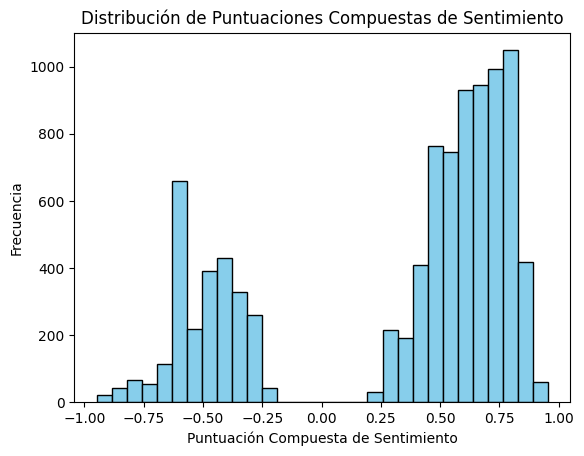

In [ ]:
def plot_sentiment_distribution(scores):
    """
    Grafica la distribución de las puntuaciones compuestas de sentimiento.

    Args:
        scores (pd.Series): Serie de puntuaciones compuestas de sentimiento.
    """
    plt.hist(scores, bins=30, color='skyblue', edgecolor='black')
    plt.xlabel('Puntuación Compuesta de Sentimiento')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de Puntuaciones Compuestas de Sentimiento')
    plt.show()

compound_scores = comments_df['sentiment'].apply(lambda x: x['compound'])
plot_sentiment_distribution(compound_scores)


Podemos concluir que la mayoría de los comentarios son positivos, con una tendencia hacia comentarios muy positivos. Esto sugiere una percepción favorable hacia la marca y sus productos por parte de los clientes.

##Depuración de problemas


In [ ]:
def identify_problems(df, threshold):
    """
    Identifica comentarios problemáticos basados en un umbral de puntuación compuesta negativa.

    Args:
        df (pd.DataFrame): DataFrame con los comentarios y sus puntuaciones de sentimiento.
        threshold (float): Umbral de puntuación compuesta negativa.

    Returns:
        pd.DataFrame: DataFrame filtrado con comentarios problemáticos.
    """
    compound_scores = df['sentiment'].apply(lambda x: x['compound'])
    problems = df[compound_scores < threshold].copy()
    return problems

problems_df = identify_problems(comments_df, -0.25)
problems_df.head(50)


,store,assigned_at,answer,processed_answer,sentiment
1,FN54,2023-02-20 17:10:31.230531,Ya no ay probadores,ya no ay probadores,"{'neg': 0.5940508544445038, 'neu': 0, 'pos': 0..."
4,T036,2023-02-21 19:25:33.154527,EL personal disperso y eso que estaba solo el ...,el personal disperso y eso que estaba solo el ...,"{'neg': 0.34849053621292114, 'neu': 0, 'pos': ..."
7,T051,2023-02-24 16:40:52.064979,Nada,nada,"{'neg': 0.3993200659751892, 'neu': 0, 'pos': 0..."
13,FN70,2023-02-25 16:55:32.171592,"Los asesores de campanario Popayan, miran a la...",los asesores de campanario popayan miran a la ...,"{'neg': 0, 'neu': 0.3263275623321533, 'pos': 0..."
15,T074,2023-02-26 11:10:31.730250,"Yo no compre en esa tienda de Bogotá, vivo en ...",yo no compre en esa tienda de bogotá vivo en o...,"{'neg': 0.40142637491226196, 'neu': 0, 'pos': ..."
18,T086,2023-02-23 19:40:50.098481,El año pasado había más promociones y mayor pr...,el año pasado había más promociones y mayor pr...,"{'neg': 0, 'neu': 0, 'pos': 0, 'compound': -0...."
23,T037,2023-02-28 19:40:33.954284,Podrían ampliar inventarios en talla 8 para ni...,podrían ampliar inventarios en talla 8 para niños,"{'neg': 0, 'neu': 0.37729358673095703, 'pos': ..."
25,FN86,2023-02-26 10:55:31.670287,La inversión debe ser igual a la calidad..,la inversión debe ser igual a la calidad,"{'neg': 0, 'neu': 0.30800899863243103, 'pos': ..."
29,T086,2023-02-25 18:10:32.905253,NA,na,"{'neg': 0, 'neu': 0.2541554272174835, 'pos': 0..."
32,T037,2023-02-28 20:40:33.629951,En diciembre realice una compra de un jean y d...,en diciembre realice una compra de un jean y d...,"{'neg': 0.24200516939163208, 'neu': 0, 'pos': ..."


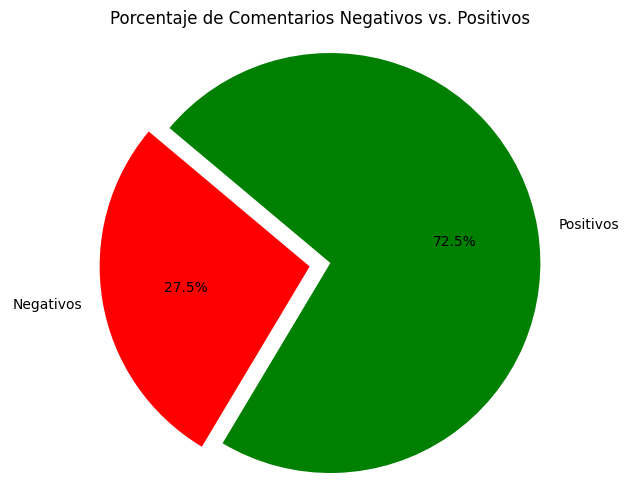

Porcentaje de comentarios negativos: 27.53%


In [ ]:
total_comments = comments_df.shape[0]

negative_comments = problems_df.shape[0]

percentage_negative = (negative_comments / total_comments) * 100

percentage_positive = 100 - percentage_negative

labels = ['Negativos', 'Positivos']
sizes = [percentage_negative, percentage_positive]
colors = ['red', 'green']
explode = (0.1, 0)

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Porcentaje de Comentarios Negativos vs. Positivos')
plt.axis('equal')
plt.show()

print(f"Porcentaje de comentarios negativos: {percentage_negative:.2f}%")


##Análisis de frecuencia en los problemas eliminando ruido manualmente

In [ ]:
stop_words = {'la', 'de', 'y', "muy", "me", "que", "en", "no", "los",
              'el', 'por', 'e', 'a', 'con', 'mi','mas','una','un', 'se', 'lo', 'al','none',
              'son', 'mas','su', 'del','sus', 'le', 'más', 'para','tienda', 'hay', 'bien',
              "ropa", 'ropa', 'prendas', 'buen', 'pero', "niños", 'q', 'exelente', "todo", "ya", "si",
              "como", "gracias", 'buena', 'compra','excelente', 'comprar', "fue", "ma"}

def analyze_word_frequency(comments, stop_words):
    """
    Analiza la frecuencia de palabras en los comentarios, excluyendo las palabras de parada.

    Args:
        comments (pd.Series): Serie de comentarios procesados.
        stop_words (set): Conjunto de palabras de parada a excluir.

    Returns:
        list: Lista de las palabras más comunes y sus frecuencias.
    """
    filtered_words = [word for comment in comments for word in comment.split() if word.lower() not in stop_words]
    word_freq = Counter(filtered_words)
    return word_freq.most_common(14)

word_freq.most_common(14)
common_words = analyze_word_frequency(problems_df['processed_answer'], stop_words)
common_words

[('atención', 269),
 ('talla', 162),
 ('variedad', 152),
 ('tallas', 152),
 ('falta', 130),
 ('solo', 129),
 ('cliente', 129),
 ('promociones', 111),
 ('poco', 110),
 ('descuento', 104),
 ('deberían', 103),
 ('cuando', 103),
 ('mala', 100),
 ('descuentos', 98)]

Con un porcentaje de comentarios negativos de el 27.5%, la empresa debería prestar atención a las preocupaciones expresadas por los clientes. Estos comentarios señalan áreas de mejora en atencion, tallas, variedad, promociones, descuentos, el servicio al cliente, la experiencia de compra,.

##Grafica de problemas por tienda

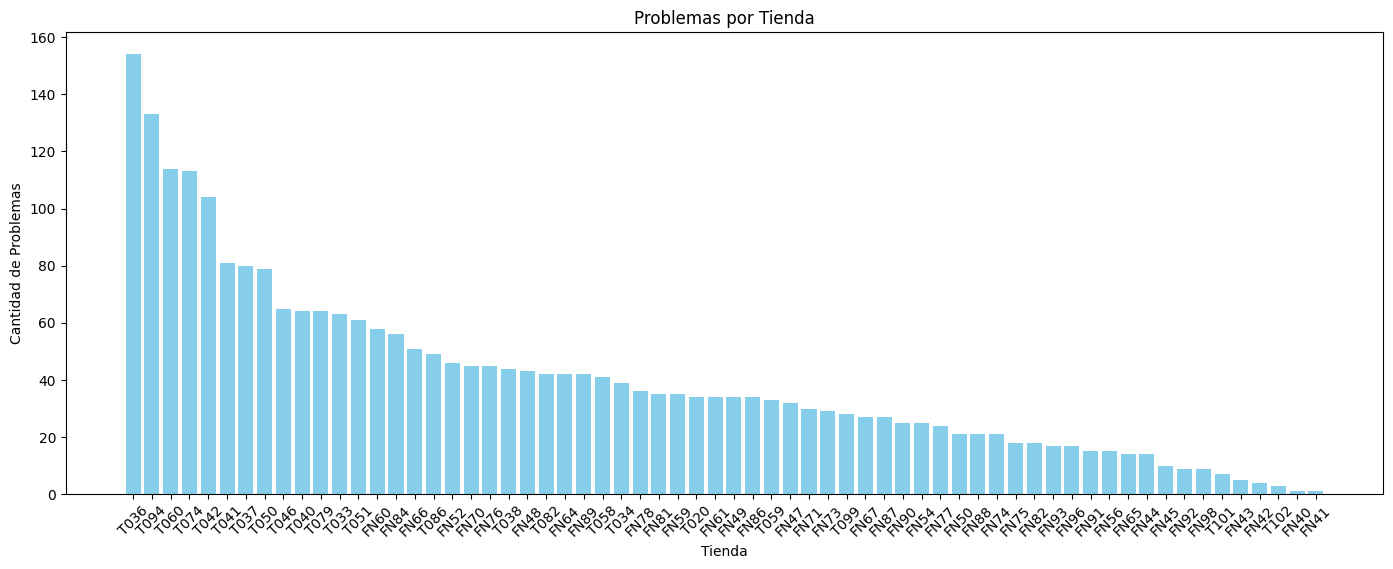

In [ ]:
def plot_problems_by_store(df):
    """
    Grafica la cantidad de problemas por tienda.

    Args:
        df (pd.DataFrame): DataFrame con los comentarios problemáticos y la información de la tienda.
    """
    store_counts = df['store'].value_counts()
    plt.figure(figsize=(17, 6))
    plt.bar(store_counts.index, store_counts.values, color='skyblue')
    plt.xlabel('Tienda')
    plt.ylabel('Cantidad de Problemas')
    plt.title('Problemas por Tienda')
    plt.xticks(rotation=45)
    plt.show()

plot_problems_by_store(problems_df)


Podemos concluir que aproximadamente 8 tiendas sobresalen por recibir predominantemente comentarios negativos, lo que sugiere áreas específicas de preocupación o descontento entre los clientes. Por otro lado, las restantes tiendas muestran una distribución más equitativa en la gráfica, lo que indica que tienen una representación similar en términos de comentarios negativos. Este patrón sugiere que las preocupaciones o problemas pueden estar más concentrados en ciertas tiendas, mientras que otras mantienen una presencia más estable en términos de satisfacción del cliente.

##Creacion de un nuevo Df con los problemas mas significativos, para tomar acciones de mejora inmediata

In [ ]:
def save_significant_problems(df, threshold, filename):
    """
    Guarda los comentarios con problemas más significativos en un archivo CSV.

    Args:
        df (pd.DataFrame): DataFrame con los comentarios y sus puntuaciones de sentimiento.
        threshold (float): Umbral de puntuación compuesta negativa para considerar un problema significativo.
        filename (str): Nombre del archivo CSV donde se guardarán los problemas.
    """
    significant_problems = identify_problems(df, threshold)
    significant_problems.to_csv(filename, index=False)
    return significant_problems

BigProblems_df = save_significant_problems(comments_df, -0.7, 'BigProblems_data.csv')
BigProblems_df.head(10)

,store,assigned_at,answer,processed_answer,sentiment
32,T037,2023-02-28 20:40:33.629951,En diciembre realice una compra de un jean y d...,en diciembre realice una compra de un jean y d...,"{'neg': 0.24200516939163208, 'neu': 0, 'pos': ..."
67,T038,2023-03-05 16:40:32.521264,Fuimos a la tienda único Cali y que pésimo ser...,fuimos a la tienda único cali y que pésimo ser...,"{'neg': 0.09679585695266724, 'neu': 0, 'pos': ..."
88,T079,2023-03-15 18:55:33.621410,Me parece injusto que metan billetes falsos y ...,me parece injusto que metan billetes falsos y ...,"{'neg': 0.12364375591278076, 'neu': 0, 'pos': ..."
91,FN49,2023-03-10 18:25:32.820920,Mal servicio de la Asesoria de la vendedora co...,mal servicio de la asesoria de la vendedora co...,"{'neg': 0.27826833724975586, 'neu': 0, 'pos': ..."
102,T036,2022-12-15 13:10:34.783003,Lamentablemente fue una experiencia negativa y...,lamentablemente fue una experiencia negativa y...,"{'neg': 0.22069627046585083, 'neu': 0, 'pos': ..."
278,FN78,2023-04-11 15:25:16.446563,Muy mala atención,muy mala atención,"{'neg': 0.1735284924507141, 'neu': 0, 'pos': 0..."
296,FN59,2023-04-09 18:40:31.926039,El sr que me atendió coloco mis datos mal ese ...,el sr que me atendió coloco mi datos mal ese n...,"{'neg': 0.12703442573547363, 'neu': 0, 'pos': ..."
345,FN54,2023-04-22 15:55:16.422216,No se porque pero en las tiendas de Bucaramang...,no se porque pero en la tiendas de bucaramanga...,"{'neg': 0.24580055475234985, 'neu': 0, 'pos': ..."
393,T099,2023-05-07 16:55:15.506765,"Muy mala la atención , estando solo tuve que e...",muy mala la atención estando solo tuve que esp...,"{'neg': 0.24616378545761108, 'neu': 0, 'pos': ..."
441,T099,2023-05-23 10:40:15.966158,Porfavor quitar mi correo de esta cédula ya qu...,porfavor quitar mi correo de esta cédula ya qu...,"{'neg': 0.2705687880516052, 'neu': 0, 'pos': 0..."


In [ ]:
total_comments = comments_df.shape[0]

negative_comments = BigProblems_df.shape[0]

percentage_negative = (negative_comments / total_comments) * 100

percentage_positive = 100 - percentage_negative

percentage_negative

1.910352187833511

Basándonos en los datos, llegamos a la conclusión de que de un total de 9370.5 comentarios analizados, solo el 1.91% se califican como altamente negativos. Esta proporción relativamente baja sugiere una percepción general positiva del servicio por parte de los clientes. Sin embargo, existe una oportunidad clara para mejorar y reducir aún más este porcentaje hacia cero. Este enfoque en la mejora continua es fundamental para garantizar altos niveles de satisfacción del cliente y fortalecer la reputación de la empresa en el mercado.

##Creacion de un df sin ruido con la ayuda de "stopwords" para el entrenamiento del modelo LDA

In [ ]:
def preprocess_text1(text):
    """
    Preprocesa el texto eliminando caracteres especiales, tokenizando, lematizando y eliminando palabras de parada.

    Args:
        text (str): El texto a preprocesar.

    Returns:
        str: El texto preprocesado.
    """
    if text is None:
        return ''

    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)

    tokens = word_tokenize(text)

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stopwords.words('spanish')]
    return ' '.join(tokens)

commentsnp_df = comments_df.copy()
commentsnp_df['processed_answer'] = commentsnp_df['answer'].apply(preprocess_text1)

commentsnp_df[['answer', 'processed_answer']].head()


,answer,processed_answer
0,"Todo lo hacen perfecto,, gracias por su atención",hacen perfecto gracias atención
1,Ya no ay probadores,ay probadores
2,Excelente servicio,excelente servicio
3,Buen servicio,buen servicio
4,EL personal disperso y eso que estaba solo el ...,personal disperso solo almacen pasan grupitos ...


Creación y entrenamiento de Modelo LDA

In [ ]:
def train_lda_model(df, num_topics=5, passes=15):
    """
    Crea y entrena un modelo LDA con los comentarios preprocesados.

    Args:
        df (pd.DataFrame): DataFrame con los comentarios preprocesados.
        num_topics (int): Número de temas para el modelo LDA.
        passes (int): Número de pasadas para el entrenamiento del modelo LDA.

    Returns:
        gensim.models.ldamodel.LdaModel: El modelo LDA entrenado.
    """
    dictionary = corpora.Dictionary([text.split() for text in df['processed_answer']])
    corpus = [dictionary.doc2bow(text.split()) for text in df['processed_answer']]
    lda_model = gensim.models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=passes)
    return lda_model

lda_model = train_lda_model(commentsnp_df)

topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.073*"marca" + 0.068*"productos" + 0.037*"encanta" + 0.032*"tienda" + 0.027*"siempre"')
(1, '0.129*"excelente" + 0.086*"atención" + 0.047*"servicio" + 0.025*"tienda" + 0.021*"cliente"')
(2, '0.028*"q" + 0.023*"bueno" + 0.011*"mejores" + 0.010*"ofertas" + 0.010*"feliz"')
(3, '0.017*"tallas" + 0.016*"ropa" + 0.016*"variedad" + 0.015*"talla" + 0.015*"niños"')
(4, '0.092*"buena" + 0.080*"calidad" + 0.080*"gracias" + 0.061*"ropa" + 0.058*"atención"')


Tema 0 - Satisfacción con la marca y productos: Este tema está caracterizado por palabras como "marca", "productos", "encanta" y "siempre", lo que sugiere que los clientes expresan satisfacción y lealtad hacia la marca y sus productos.

Tema 1 - Excelente atención al cliente: Este tema se centra en aspectos relacionados con el servicio al cliente, con términos como "excelente", "atención" y "servicio". Esto indica que los clientes valoran altamente la calidad del servicio recibido.

Tema 2 - Opiniones mixtas sobre ofertas y calidad: Este tema parece reflejar opiniones mixtas, con términos como "bueno", "ofertas" y "feliz". Esto puede indicar que algunos clientes están satisfechos con las ofertas y la calidad, mientras que otros podrían tener opiniones menos favorables.

Tema 3 - Variedad y tallas en la ropa para niños: Este tema se centra en aspectos relacionados con la variedad de productos y las tallas de la ropa para niños, lo que sugiere que los clientes aprecian la diversidad de opciones disponibles.

Tema 4 - Agradecimiento y atención a la calidad de la ropa: Este tema destaca la importancia de la calidad de la ropa y la atención al cliente, con términos como "buena", "calidad" y "gracias". Esto indica que los clientes están agradecidos por la calidad de los productos y el servicio recibido.



#Conclución final.

En este proyecto, he logrado identificar varios temas importantes en los comentarios de los clientes. La mayoría de los clientes están satisfechos con la marca y sus productos, destacando la calidad y el excelente servicio al cliente. Sin embargo, también hay opiniones mixtas sobre las ofertas y la calidad, lo que sugiere que hay áreas para mejorar. La variedad y la disponibilidad de tallas en la ropa para niños son aspectos altamente valorados, y muchos clientes muestran su agradecimiento por la atención y la calidad de la ropa.

Este análisis me ha permitido obtener una comprensión más profunda de las percepciones y expectativas de los clientes, lo que puede ser fundamental para guiar futuras estrategias de marketing y mejorar la oferta de productos y servicios. La utilización de técnicas de NLP y modelos de LDA ha demostrado ser una herramienta poderosa para transformar grandes volúmenes de datos no estructurados en información accionable y valiosa.








